In [24]:
import scanpy as sc
import sys
sys.path.append("../")
import trvaep
from trvaep import pl

## loading and preparing data 

In [7]:
adata = sc.read("../data/kang_seurat.h5ad", backup_url="shorturl.at/tNS17")
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
adata = adata[:, adata.var['highly_variable']]
n_conditions = adata.obs["condition"].unique().shape[0]

In [8]:
adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                      & (adata.obs["condition"] == "CTRL"))]

In [9]:
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)


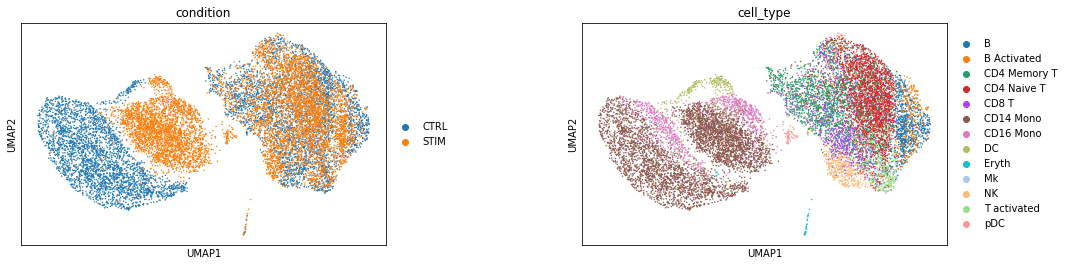

In [10]:
sc.pl.umap(adata_train, color=["condition", "cell_type"], wspace=.4)

## creating model object 

In [11]:
model = trvaep.CVAE(adata_train.n_vars, num_classes=n_conditions,
            encoder_layer_sizes=[128, 32], decoder_layer_sizes=[32, 128], latent_dim=10, alpha=0.0001,
            use_mmd=True, beta=10)

### Make a trainer object 

In [12]:
trainer = trvaep.Trainer(model, adata_train)

In [13]:
trainer.train_trvae(200, 512, early_patience=30)

Epoch 00/100 Batch 0000/23, Loss:  478.4371, rec_loss:  476.0429, KL_loss:    0.0002, MMD_loss:     2.3941
Epoch 00/100 Batch 0023/23, Loss:  196.0147, rec_loss:  193.9614, KL_loss:    0.0006, MMD_loss:     2.0528
Epoch 01/100 Batch 0000/23, Loss:  179.7059, rec_loss:  177.6258, KL_loss:    0.0006, MMD_loss:     2.0794
Epoch 01/100 Batch 0023/23, Loss:  139.2348, rec_loss:  137.3995, KL_loss:    0.0012, MMD_loss:     1.8341
Epoch 02/100 Batch 0000/23, Loss:  130.3916, rec_loss:  128.2588, KL_loss:    0.0013, MMD_loss:     2.1315
Epoch 02/100 Batch 0023/23, Loss:  111.1803, rec_loss:  108.7627, KL_loss:    0.0017, MMD_loss:     2.4159
Epoch 03/100 Batch 0000/23, Loss:  116.7637, rec_loss:  114.3978, KL_loss:    0.0018, MMD_loss:     2.3641
Epoch 03/100 Batch 0023/23, Loss:  104.8216, rec_loss:  102.9196, KL_loss:    0.0022, MMD_loss:     1.8998
Epoch 04/100 Batch 0000/23, Loss:  104.2241, rec_loss:  101.9634, KL_loss:    0.0022, MMD_loss:     2.2584
Epoch 04/100 Batch 0023/23, Loss:  10

## visualizing the MMD latent space

... storing 'cell_type' as categorical
... storing 'condition' as categorical


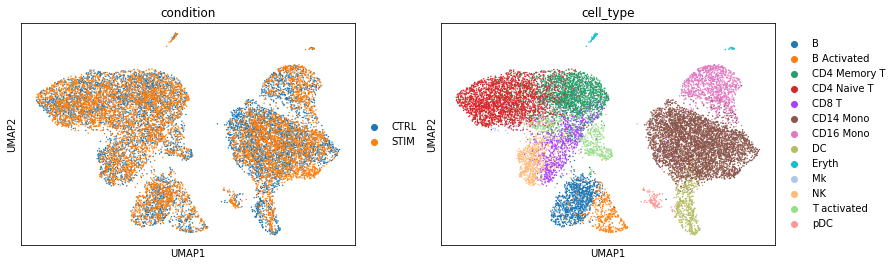

In [14]:
latent_y = model.get_y(
    adata.X.A, model.label_encoder.transform(adata.obs["condition"]))
adata_latent = sc.AnnData(latent_y)
adata_latent.obs["cell_type"] = adata.obs["cell_type"].tolist()
adata_latent.obs["condition"] = adata.obs["condition"].tolist()
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color=["condition", "cell_type"])

## Making prediction

layers are inconsistent - only layers that are shared among all AnnData objects are included.
... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'orig.ident' as categorical
... storing 'seurat_annotations' as categorical
... storing 'stim' as categorical


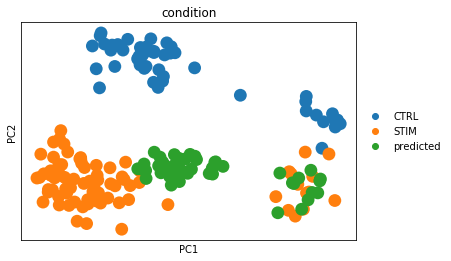

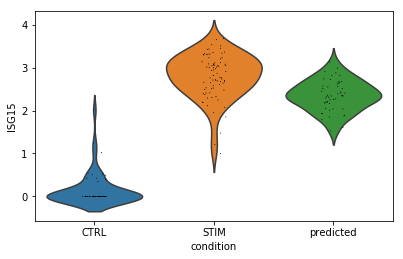

In [15]:
ground_truth = adata[(adata.obs["cell_type"] == "pDC")]
adata_source = adata[(adata.obs["cell_type"] == "pDC") &
                     (adata.obs["condition"] == "CTRL")]
predicted_data = model.predict(x=adata_source.X.A, y=adata_source.obs["condition"].tolist(),
                               target="STIM")
adata_pred = sc.AnnData(predicted_data)
adata_pred.obs["condition"] = np.tile("predicted", len(adata_pred))
adata_pred.var_names = adata_source.var_names.tolist()
all_adata = ground_truth.concatenate(adata_pred)
sc.tl.pca(all_adata)
sc.pl.pca(all_adata, color=["condition"])
sc.pl.violin(all_adata, keys="ISG15", groupby="condition")

## Mean correlation plot


In [20]:
sc.tl.rank_genes_groups(ground_truth, groupby="condition", method="wilcoxon")
diff_genes = ground_truth.uns["rank_genes_groups"]["names"]["STIM"]

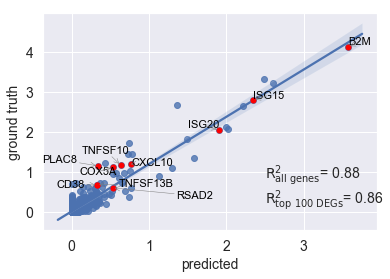

In [23]:
r2_value = pl.reg_mean_plot(all_adata, condition_key="condition",
                                        axis_keys={
                                            "x": "predicted", "y": "STIM"},
                                        gene_list=diff_genes[:10],
                                        top_100_genes= diff_genes,
                                        labels={"x": "predicted",
                                                "y": "ground truth"},
                                        path_to_save="./reg_mean1.pdf",
                                        show=True,
                                        legend=False)